# Samuel Watkins, 3032132676

# HW 5: Database
## Weather Prediction, due Monday Mar 12, 2018 at 2 PM

In this assignment, we will create a database to analyze historical weather data and discover the relationships between major cities.

1. Find a list of the 50 most travelled airports in the US and make a table containing the relevant information, such as name, nearest city, latitude, and longitude.
2. Build another table that will hold historical weather information, such as min/max temperature, humidity, and precipitation.
3. Build a web crawler that will pull historical data from Weather Underground from 2008 until now and populate your tables accordingly.
4. For each pair of cities/airports, determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1, 3, and 7 days in advance.
5. Plot the correlation strengths for the 10 top pairs for all three dates for temperature and precipitation (separately) as a function of distance. Also, make a plot as a function of longitude. What trends do you see?

# 1. List of 50 Most Travelled Airports

A list of all airports with latitude, longitude, altitude, codes, and more was found at [this link](https://openflights.org/data.html). A CSV can be downloaded that contains all of the information, called `airports.dat`.  
A list of the 50 most travelled airports in the US was found at [this link](https://www.rita.dot.gov/bts/sites/rita.dot.gov.bts/files/publications/national_transportation_statistics/html/table_01_44.html/). A CSV can be downloaded called `table_01_44_5.csv`, which contains the airport name, closest city, and the airport code.

In [1]:
import pandas as pd
import sqlite3

In [ ]:
# read the CSV containing the codes of the 50 most travelled airports
most_travelled_airports = pd.read_csv('table_01_44_5.csv',sep=',',skiprows=4,
                                      usecols=[1],names=["IATA Code"],skipfooter=11,engine="python")

# read the CSV containing information on all airports
all_airports = pd.read_csv('airports.dat',sep=',',usecols=[1,2,3,4,5,6,7,8],
                           names=["Name","City","Country","IATA Code","ICAO Code","Latitude","Longitude","Altitude"])

# merge the CSVs such that we have all relevant information necessary on the 50 most travelled airports
most_travelled_airports = most_travelled_airports.merge(all_airports,how="left",on="IATA Code")

In [2]:
# connect to the database (or create it if it doesn't exist yet)
connection = sqlite3.connect("airport_data.db")
cursor = connection.cursor()

In [ ]:
# let's create an airports table to store all of the information
sql_cmd = """CREATE TABLE airports (aid INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT, city TEXT, country TEXT, iata TEXT, icao TEXT, latitude FLOAT, longitude FLOAT, altitude FLOAT)"""

cursor.execute(sql_cmd)

# now populate the table
for ii,row in most_travelled_airports.iterrows():
    name = row["Name"].replace("'","`")
    city = row["City"]
    country = row["Country"]
    icao = row["ICAO Code"]
    iata = row["IATA Code"]
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    altitude = row["Altitude"]
    
    sql_cmd = "INSERT INTO airports" + \
              "(name, city, country, iata, icao, latitude, longitude, altitude)" + \
              f""" VALUES ('{name}','{city}','{country}','{iata}','{icao}',{latitude},{longitude},{altitude})"""
    cursor.execute(sql_cmd)
connection.commit()


# 2. Table for Storing Weather Information

In [ ]:
# now let's create a weather table to store all of the weather information
sql_cmd = """CREATE TABLE weather (wid INTEGER PRIMARY KEY AUTOINCREMENT, aid INTEGER, date DATE,
    mintemp FLOAT, maxtemp FLOAT, meantemp FLOAT, precip FLOAT, windspeed FLOAT, humidity FLOAT)"""

cursor.execute(sql_cmd);

# 3. Web Crawler To Populate Weather Table

The web crawler navigates to the Custom History page of each airport from the airports table in the database on Weather Underground. In year long intervals, it reads the values from the table on the webpage by matching the link of the first value in the row to the expected date, and then looking for the table data via searching for the tag `<td>` (all using BeautifulSoup). If any data is missing, then it will be populated with NULL values.

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime

In [ ]:
# now let's crawl the wunderground pages to get all of the weather

# specify the years, days in year, and today's date
years = 10
daysInYear = 365.24
dateToday = datetime.datetime.today()

# get all of the airport IDs and codes to match the weather data with
sql_cmd = """SELECT airports.aid,airports.icao FROM airports """
cursor.execute(sql_cmd);
airport_names = cursor.fetchall()

# loop through all 50 airports
for aid, airport_name in airport_names:
    
    # define the start date to begin web crawling from
    dateLast = datetime.datetime.today() - datetime.timedelta(days=years*daysInYear)

    # loop over the specified amount of years
    for _ in range(years):
        # specify the end date of the range we will be looking at
        dateNext = dateLast + datetime.timedelta(days=daysInYear)
        
        # if the date is in the future, we use today's date
        if dateNext > datetime.datetime.today():
            dateNext = datetime.datetime.today()
        
        # create a date range that goes through every day between the specified start and end dates
        date_range = pd.date_range(start=dateLast,end=dateNext)
        
        # determine what the wunderground url is that we will navigate to
        urlDateStart = dateLast.strftime("%Y/%m/%d")
        urlDateEnd = dateNext.strftime("dayend=%d&monthend=%m&yearend=%Y")
        url = f"https://www.wunderground.com/history/airport/{airport_name}/{urlDateStart}/"+\
              f"CustomHistory.html?{urlDateEnd}"
        
        # parse the html of the webpage
        response = urlopen(url)
        html = response.read()
        response.close()
        soup = BeautifulSoup(html,"html.parser")

        # loop over all the days in the date range to store the weather data
        for date in date_range:
            # find the column in the table on the webpage that corresponds to the specified date
            urlSingleDate = date.strftime("%Y/%-m/%-d")
            sqlDate = date.strftime("%Y-%m-%d")
            dataID = soup.select(f'a[href="/history/airport/{airport_name}/{urlSingleDate}/DailyHistory.html"]')
            
            if len(dataID)>0:
                # there are 19 rows in each column of the table on the webpage, 
                row = dataID[0].find_all_next("td",limit=19)
                
                # check if any of the values have no data, set as NULL if this is the case
                # get rid newline characters and spaces for simple conversion to float
                values = list()
                for value in row:
                    if value.get_text().replace('\n','').replace(' ','') == '-':
                        values.append("NULL")
                    elif value.get_text().replace('\n','').replace(' ','') == 'T':
                        values.append(0.0) # assume 0 inches of precipitation when trace precipitation is measured
                    else:
                        values.append(float(value.get_text().replace('\n','').replace(' ','')))
                
                # choose the values that we will be saving
                maxtemp = values[0]
                meantemp = values[1]
                mintemp = values[2]
                humidity = values[7]
                windspeed = values[16]
                precip = values[18]
                
            else:
                # there is no data for this date, so set all values as NULL
                maxtemp = "NULL"
                meantemp = "NULL"
                mintemp = "NULL"
                humidity = "NULL"
                windspeed = "NULL"
                precip = "NULL"
            
            # insert the weather data for this date into our table 
            sql_cmd = "INSERT INTO weather" + \
                      "(aid, date, mintemp, maxtemp, meantemp, precip, windspeed,humidity)" + \
                      f""" VALUES ({aid},'{sqlDate}',{mintemp},{maxtemp},{maxtemp},{precip},{windspeed},{humidity})"""
            
            cursor.execute(sql_cmd);
        # reset the start date to the next day after the previous date range
        dateLast = dateNext + datetime.timedelta(days=1)

# commit the transaction
connection.commit()


# 4. Predicting Changes in Weather

Generating all possible permutations of pairs of the 50 airports, we then read in the daily max temperature and precipitation for the last 10 years. Using Pandas, we create a DataFrame and compute the daily change in the values, dropping any days that are NaN. This will result in some jumps in the days, but this is an uncommon occurrence, so the effect should be minimal when considering how much data we have. We then use `np.corrcoef` to extract the correlation between pairs with 1, 3, and 7 day offsets between each pair for both max temperature and precipitation.

In [3]:
import numpy as np
import itertools

In [80]:
# get all of the airport IDs
sql_cmd = """SELECT airports.aid FROM airports"""
cursor.execute(sql_cmd)

# get all airport IDs, create an array contains all possible pairs of the 50 airports
aids = np.concatenate(np.array(cursor.fetchall()))
perms = np.array(list(itertools.permutations(aids,2)))

nPerms = len(perms)

# initialize the arrays that we will store the correlations in 
maxTempCorrs = np.zeros((len(perms),3))
precipCorrs = np.zeros((len(perms),3))

# loop over all of the possible pairs of 2 airports
for iPerm in range(nPerms):
    perm = perms[iPerm]

    # get the max temperature and precipitation for both airports in the pair
    db_data = list()
    for ii in range(2):
        sql_cmd = f"""SELECT weather.maxtemp,weather.precip FROM weather 
                     WHERE weather.aid = {perm[ii]}"""

        cursor.execute(sql_cmd);
        db_data.append(np.array(cursor.fetchall()))

    # combine the data into one table, storing in a pandas DataFrame, dropping any dates with NULL values
    db_data = np.hstack(np.array(db_data,dtype=np.float))
    permData = pd.DataFrame(db_data,columns=["maxtemp1","precip1","maxtemp2","precip2"]).dropna()
    
    # compute the correlation between the max temperature change between the airports for 1, 3, and 7 day differences
    maxTempCorr1 = np.corrcoef(permData.maxtemp1.diff().dropna().values[:-1],
                               y=permData.maxtemp2.diff().dropna().values[1:])[0,1]
    
    maxTempCorr3 = np.corrcoef(permData.maxtemp1.diff().dropna().values[:-3],
                               y=permData.maxtemp2.diff().dropna().values[3:])[0,1]
    
    maxTempCorr7 = np.corrcoef(permData.maxtemp1.diff().dropna().values[:-7],
                               y=permData.maxtemp2.diff().dropna().values[7:])[0,1]
    
    maxTempCorrs[iPerm,:] = np.array([maxTempCorr1,maxTempCorr3,maxTempCorr7])
    
    # compute the correlation between the precipitation change between the airports for 1, 3, and 7 day differences
    precipCorr1 = np.corrcoef(permData.precip1.diff().dropna().values[:-1],
                                 y=permData.precip2.diff().dropna().values[1:])[0,1]
    
    precipCorr3 = np.corrcoef(permData.precip1.diff().dropna().values[:-3],
                                 y=permData.precip2.diff().dropna().values[3:])[0,1]
    
    precipCorr7 = np.corrcoef(permData.precip1.diff().dropna().values[:-7],
                                 y=permData.precip2.diff().dropna().values[7:])[0,1]
    
    precipCorrs[iPerm,:] = np.array([precipCorr1,precipCorr3,precipCorr7])

# 5. Plotting the Results

With the correlation coefficients calculated, we now plot the results. We also use the latitude and longitude of each airport to calculate the distance and the difference in longitude for each pair. The plots and their analysis are below.

In [81]:
import matplotlib.pyplot as plt
% matplotlib inline

def distanceOnSphere(lat1,lon1,lat2,lon2):
    # takes in latitude and longitude of two points in degrees,
    # outputs the great circle distance using the haversine formula (see Wikipedia)
    
    rEarth = 6371000.0 # radius of Earth in meters
    
    lat1*=np.pi/180
    lon1*=np.pi/180
    lat2*=np.pi/180
    lon2*=np.pi/180
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2.0 + np.cos(lat1)*np.cos(lat2) * np.sin(dlon/2)**2.0
    d = 2 * rEarth * np.sqrt(a)
    return d

nMax = 10 # number of pairs with highest correlation to plot

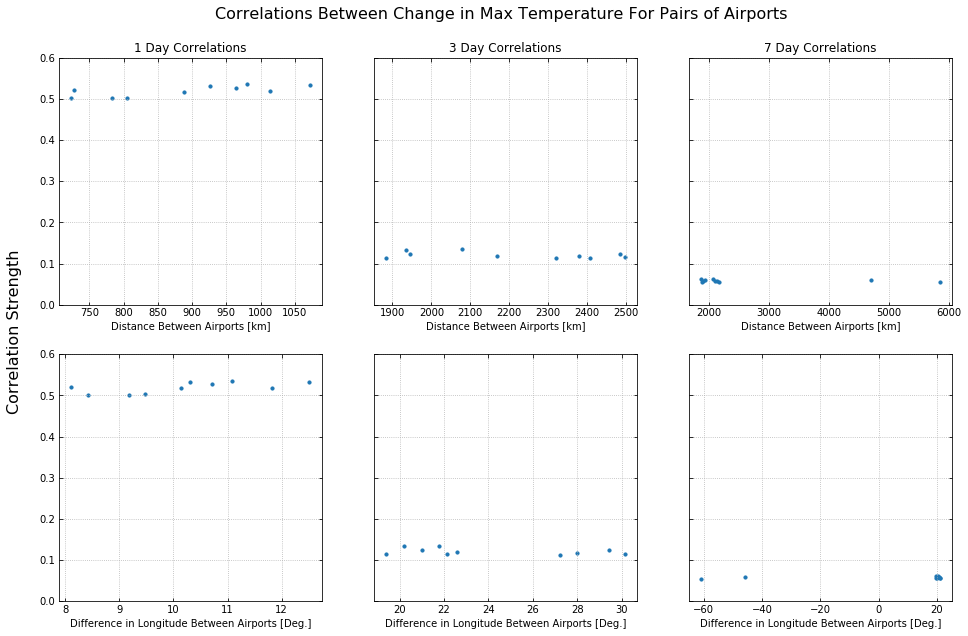

In [98]:
# create a figure to plot the correlation strengths as functions of distance between and difference in longitude
fig, ax = plt.subplots(2, 3, sharey='row',figsize=(16,10))
fig.text(0.08, 0.5, 'Correlation Strength', va='center', rotation='vertical',fontsize=16)
fig.text(0.26, 0.94, 'Correlations Between Change in Max Temperature For Pairs of Airports',va='center',fontsize=16)

labels = ["1 Day Correlations","3 Day Correlations","7 Day Correlations"]

# loop over the 1, 3, and 7 day differences
for iDiff in range(3):
    
    # find the pairs of airports with the highest correlation
    corrStrength = maxTempCorrs[:,iDiff]
    maxInds = corrStrength.argsort()[::-1][:nMax]
    bestPerms = perms[maxInds]
    
    distances = np.zeros(nMax)
    dlongitude = np.zeros(nMax)
    
    # for each airport pair, determine the distance between the airports and the difference in longitude
    for iMax in range(nMax):
        perm = bestPerms[iMax]
        latlon = np.zeros((2,2))
        for iPerm in range(2):
            # get the latitude and longitude
            sql_cmd = f"""SELECT airports.latitude,airports.longitude FROM airports 
                         WHERE airports.aid = {perm[iPerm]}"""

            cursor.execute(sql_cmd);
            latlon[iPerm] = np.array(cursor.fetchall(),dtype = np.float)
            
        distances[iMax] = distanceOnSphere(latlon[0,0],latlon[0,1],latlon[1,0],latlon[1,1])
        dlongitude[iMax] = latlon[1,1]-latlon[0,1]
    
    # plot the results
    ax[0,iDiff].scatter(distances*1e-3,corrStrength[maxInds],s=10.0)
    ax[0,iDiff].tick_params(which="both",top="on",right="on",direction="in")
    ax[0,iDiff].grid(linestyle="dotted")
    ax[0,iDiff].set_title(labels[iDiff])
    ax[0,iDiff].set_xlabel("Distance Between Airports [km]")
    ax[0,iDiff].set_ylim([0,0.6])
    
    ax[1,iDiff].scatter(dlongitude,corrStrength[maxInds],s=10.0)
    ax[1,iDiff].tick_params(which="both",top="on",right="on",direction="in")
    ax[1,iDiff].grid(linestyle="dotted")
    ax[1,iDiff].set_xlabel("Difference in Longitude Between Airports [Deg.]")
    ax[1,iDiff].set_ylim([0,0.6])
    

**Analysis**: We see from the above plots that the pairs of airports have the highest correlation for a 1 day offset. It then significantly decreases when we move to a 3 day offset and decreases a little more for the 7 day offset.  

We also note that the airports are closer together for the 1 day offset, as we would expect due to weather moving over time.. The 3 day and 7 day offsets have similar distances for the pairs, with a couple of outliers for the 7 day offset.  

Lastly, we note that the difference in longitude is positive for nearly all of the pairs for each offset (the 7 day offset has two outliers). This implies that the max temperature changes move from west to east.

It seems that the max temperature is a decent predictor for 1 day offsets, a marginal predictor for 3 day offsets, and a poor predictor for 7 day offsets.

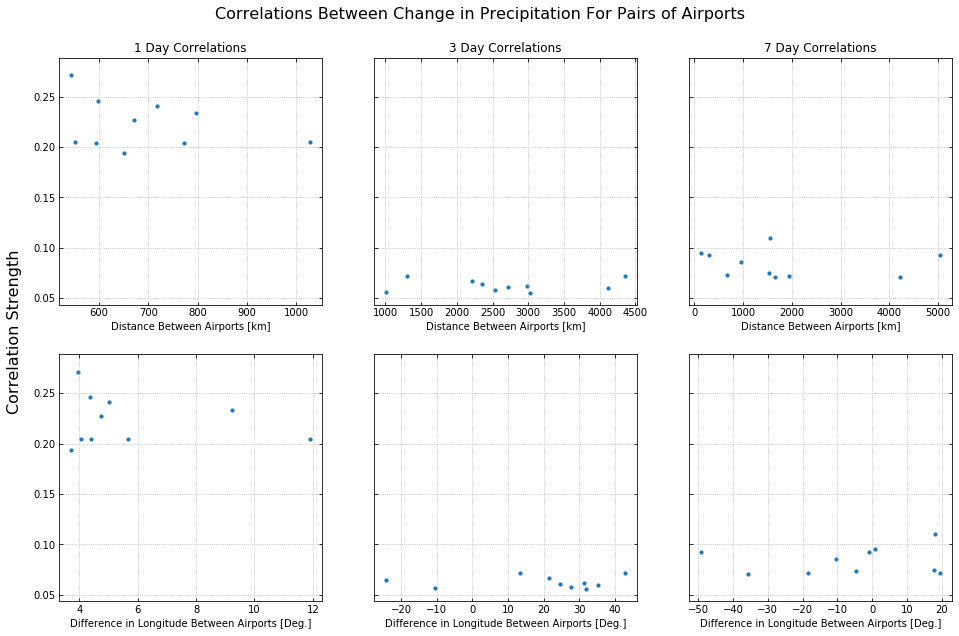

In [100]:
# create a figure to plot the correlation strengths as functions of distance between and difference in longitude
fig, ax = plt.subplots(2, 3, sharey='row',figsize=(16,10))
fig.text(0.08, 0.5, 'Correlation Strength', va='center', rotation='vertical',fontsize=16)
fig.text(0.26, 0.94, 'Correlations Between Change in Precipitation For Pairs of Airports',va='center',fontsize=16)

labels = ["1 Day Correlations","3 Day Correlations","7 Day Correlations"]

# loop over the 1, 3, and 7 day differences
for iDiff in range(3):
    
    # find the pairs of airports with the highest correlation
    corrStrength = precipCorrs[:,iDiff]
    maxInds = corrStrength.argsort()[::-1][:nMax]
    bestPerms = perms[maxInds]
    distances = np.zeros(nMax)
    dlongitude = np.zeros(nMax)
    
    # for each airport pair, determine the distance between the airports and the difference in longitude
    for iMax in range(nMax):
        perm = bestPerms[iMax]
        latlon = np.zeros((2,2))
        for iPerm in range(2):
            # get the latitude and longitude
            sql_cmd = f"""SELECT airports.latitude,airports.longitude FROM airports 
                         WHERE airports.aid = {perm[iPerm]}"""

            cursor.execute(sql_cmd);
            latlon[iPerm] = np.array(cursor.fetchall(),dtype = np.float)
            
        distances[iMax] = distanceOnSphere(latlon[0,0],latlon[0,1],latlon[1,0],latlon[1,1])
        dlongitude[iMax] = latlon[1,1]-latlon[0,1]
        
    # plot the results
    ax[0,iDiff].scatter(distances*1e-3,corrStrength[maxInds],s=10.0)
    ax[0,iDiff].tick_params(which="both",top="on",right="on",direction="in")
    ax[0,iDiff].grid(linestyle="dotted")
    ax[0,iDiff].set_title(labels[iDiff])
    ax[0,iDiff].set_xlabel("Distance Between Airports [km]")
    
    ax[1,iDiff].scatter(dlongitude,corrStrength[maxInds],s=10.0)
    ax[1,iDiff].tick_params(which="both",top="on",right="on",direction="in")
    ax[1,iDiff].grid(linestyle="dotted")
    ax[1,iDiff].set_xlabel("Difference in Longitude Between Airports [Deg.]")

**Analysis**: We see from the above plots that the pairs of airports have the highest correlation for a 1 day offset. It then significantly decreases when we move to a 3 day offset. The 3 day offset and 7 day offset are about the same.  

We also note that the airports are closer together for the 1 day offset as compared to the other offsets, as we would expect due to weather moving over time. The 7 day offset has a large range in distances for the top 10 pairs. This implies that the predictive power of the 7 day offset is poor, as the (low) correlation seems independent of distance.

We note that the difference in longitude is positive for the 1 day offset, meaning that the precipitation changes are moving from west to east. The 3 day ofset also has a (mostly) positive longitude difference, with a couple of outliers. The 7 day offset is all over the place.

Thus, it seems that the 1 day offset is a decent predictor of precipitation, while the 